In [27]:
%%HTML
<link rel="stylesheet" href="custom.css">

# <span style="color:maroon"> Data assimilation, machine learning and dynamical systems - Part II  </span>
#### Marc Bocquet¹ [marc.bocquet@enpc.fr](mailto:marc.bocquet@enpc.fr) and Julien Brajard² [julien.brajard@nersc.no](mailto:julien.brajard@nersc.no)
#### (1) CEREA, École des Ponts et EdF R&D, Île-de-France, France
#### (2) Nansen Center (NERSC), Bergen, Norway

During this session, we will discover some connections between data assimilation and deep learning when applied to dynamical systems.

# <span style="color:teal"> Second step: Learn the model error through machine learning learning </span>

In this notebook, we will use the output of data assimilation to train a neural network into predicting the model error. The procedure is the following:
- The **analysis** $x^{\rm a}_k$ is used as the best possible estimate from the truth at time step $t_k$.
- The physical model is used to produced a **forecast** $x^{\rm f}_{k}$ using the analysis $x^{\rm a}_{k-1}$ as initial conditions.
- For each time $t_k$, the difference between the forecast and the analysis is used to estimate the **model error** $\mathrm{err}_k = x^{\rm a}_k - x^{\rm f}_k$
- A **neural network** taking $x^{\rm a}_{k-1}$ as an input is trained, supervised by the data $\mathrm{err}_k$
<p align = "center">
<img src="./Figures/scheme-err.png" alt="Model error estimation" width="800"/>
</p>

## <span style="color:blue"> I. Check the result of data assimilation </span>
Before training the neural network, as it is recommanded for *any* machine learning process, we have a look at the data.


In [32]:
# Import standard modules
import pathlib
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
from tqdm.notebook import trange, tqdm
from pickle import dump


from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Layer
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers
from tensorflow.keras import Model
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error

# Folder for results
folder = dict(output = pathlib.Path("./Output"))

# For plot customisation
sns.set_context('notebook')
sns.set_style('darkgrid')
plt.rc('axes', linewidth=1)
plt.rc('axes', edgecolor='k')
plt.rc('figure', dpi=100)
palette = sns.color_palette('deep')

First, we load the result of the data assimilation, the so-called **anlaysis**. We also load the truth to plot some diagnostics.

In [33]:
# Load the analysis:
xa = np.load(dir['output'] / 'xa.npy')

# Load the truth
xt = np.load(dir['output'] / 'xt.npy')


Here we define the physical model so to compute the forecast.

In [34]:
# Check that the parameters of L96 are the same as in the first notebook.
from Model.lorenz96 import l96
Nx = 40
dt = 0.05
F = 8
phi = l96(Nx, dt, F)

In the standard configuration, the best estimate we have from the system is the analysis. 

Here, as we know the truth, we can choose to use the true value of the L96 variable instead of the analysis.  Then, the data are **perfect**, there is no error due to the observation error, the observation sampling and the data assimilation process. It is an ideal case, but it cannot be achieved for most of the realistic system.

If you want to do the test with perfect data, you just have to umcomment the line ```learning = 'truth'```. It is expected to be much easier to learn the model error as there is not additionnal noise.



In [5]:
learning = 'analysis'
#learning = 'truth'
if learning == 'analysis':
    x = xa
else:
     x = xt #learn on the true error

In [6]:
# Compute the forecast of the physical model
xf = x + phi(x)

# Compute the model error
err = x[1:] - xf[:-1]

## Diagnostics

In [7]:
def scatter_plot(x,y,ax=None):
    ax = sns.regplot(x=x, y=y, ax=ax)
    r2 = r2_score(x, y)
    mse = mean_squared_error(x, y, squared=False)
    ax.set_title(f'R2={r2:.2f}, RMSE={mse:.2e}')
    return ax

Text(0, 0.5, 'Analysis RMSE')

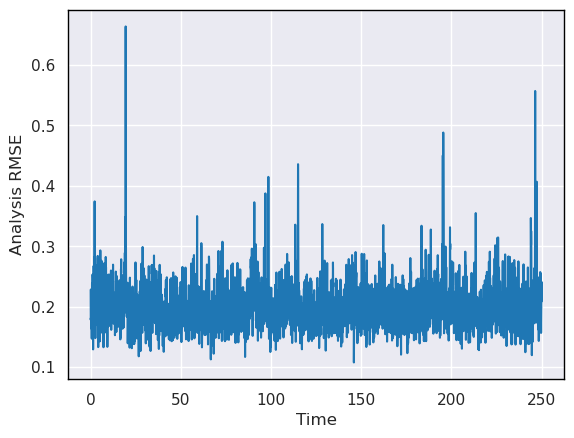

In [8]:
rmse_time = np.sqrt(np.mean(np.square(xt-xa),axis=1))
plt.plot(dt*np.arange(rmse_time.shape[0]),rmse_time)
plt.xlabel('Time')
plt.ylabel('Analysis RMSE')

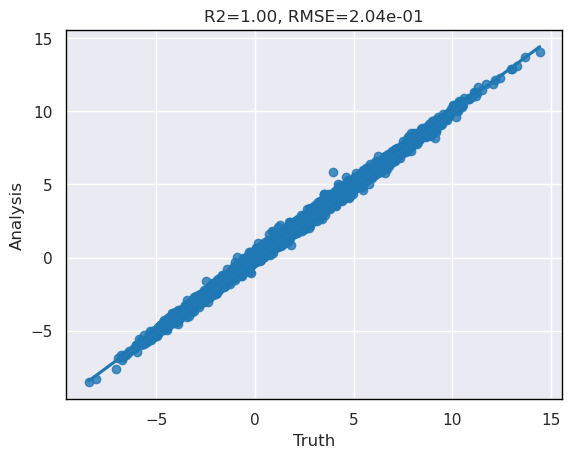

In [9]:
ax = scatter_plot (xt[:,20], xa[:,20])
ax.set_xlabel('Truth')
ax.set_ylabel('Analysis');
plt.savefig('Figures/scatter_analysis')

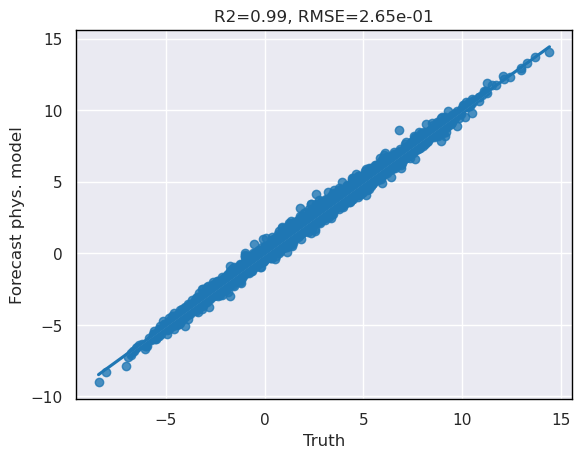

In [10]:
ax = scatter_plot (xt[1:,20], xf[:-1,20])
ax.set_xlabel('Truth')
ax.set_ylabel('Forecast phys. model');
plt.savefig('Figures/scatter_phiforecast')


In [11]:
xp1 = np.roll(x, shift=1, axis=-1)
xp2 = np.roll(xp1, shift=1, axis=-1)
xp3 = np.roll(xp2, shift=1, axis=-1)
xm1 = np.roll(x, shift=-1, axis=-1)
xm2 = np.roll(xm1, shift=-1, axis=-1)
p1 = (xp2*x*(xm1-xp3)-xp1*xm1*(xm2-xp2))        

<AxesSubplot: >

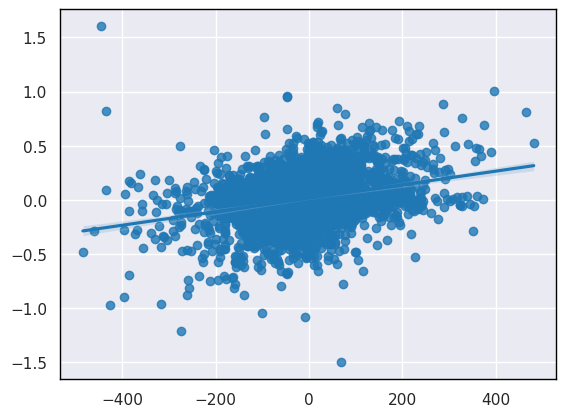

In [12]:
sns.regplot(x=p1[1:,20],y=err[:,20])

## Build the NN model

In [13]:
import random, os
seed = 1980
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
tf.random.set_seed(seed)
np.random.seed(seed)

In [14]:
class Periodic1DPadding(Layer):
    """Add a periodic padding to the output
    # Arguments
        padding_size: tuple giving the padding size (left, right)
    # Output Shape
        input_shape+left+right
    """


    def __init__ (self, padding_size, **kwargs):
        super(Periodic1DPadding, self).__init__(**kwargs)
        if isinstance(padding_size, int):
            padding_size = (padding_size, padding_size)
        self.padding_size = tuple(padding_size)

    def compute_output_shape( self, input_shape ):
        space = input_shape[1:-1]
        if len(space) != 1:
            raise ValueError ('Input shape should be 1D with channel at last')
        new_dim = space[0] + np.sum(self.padding_size)
        return (input_shape[0],new_dim,input_shape[-1])



    def build( self , input_shape):
        super(Periodic1DPadding,self).build(input_shape)

    def call( self, inputs ):
        vleft, vright = self.padding_size
        leftborder = inputs[:, -vleft:, :]
        rigthborder = inputs[:, :vright, :]
        return K.concatenate([leftborder, inputs, rigthborder], axis=-2)

In [15]:
def buildmodel(archi, m=40, reg=1e-5, batchlayer=1):

    inputs = Input(shape=(m,1))
    border = int(np.sum(np.array([kern//2 for nfil,kern,activ in archi])))
    x = Periodic1DPadding(padding_size=border)(inputs)
    x = BatchNormalization()(x)
    for i, (nfil, kern, activ) in enumerate(archi):
        if i == batchlayer:
            x = BatchNormalization()(x)
        x = Conv1D(nfil, kern, activation=activ)(x)
    output= Conv1D(1,1,activation='linear', kernel_regularizer=regularizers.l2(reg))(x)
    return Model(inputs,output)


In [16]:
archi = [(40, 7, 'tanh'),
         (20, 5, 'tanh'),
         (20, 1, 'tanh')
        ]

In [17]:
model = buildmodel(archi)

2022-12-20 16:37:14.698598: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Train the model

In [18]:
frac_train = .8
burnin = 5
vallast = True

X = x[burnin:-1]
y = err[burnin:]

itrain = int(frac_train*X.shape[0])
if vallast == True:
    Xtrain, ytrain = X[:itrain], y[:itrain]
    Xval, yval = X[itrain:], y[itrain:]
else:
    Xtrain, ytrain = X[-itrain:], y[-itrain:]
    Xval, yval = X[:-itrain], y[:-itrain]
print(f'Total number of samples: {X.shape[0]}')
print(f'Number of training samples: {Xtrain.shape[0]}')
print(f'Number of validationsamples: {Xval.shape[0]}')
print(f'Number of input feature: {Xval.shape[1]}')

Total number of samples: 4994
Number of training samples: 3995
Number of validationsamples: 999
Number of input feature: 40


In [19]:
scaler_x = StandardScaler().fit(Xtrain)
scaler_y = StandardScaler().fit(ytrain)


In [20]:
model.compile(loss='mse', optimizer='adam')

In [21]:
from utils import tqdm_callback
num_epochs = 500     
callbacks = [ tqdm_callback(num_epochs, 'naive NN training') ]

history = model.fit(scaler_x.transform(Xtrain), scaler_y.transform(ytrain), 
                    epochs=num_epochs, 
                    batch_size=256, 
                    validation_data = (scaler_x.transform(Xval), scaler_y.transform(yval)),
                    verbose=0, callbacks=callbacks)

naive NN training:   0%|          | 0/500 [00:00<?, ?it/s]

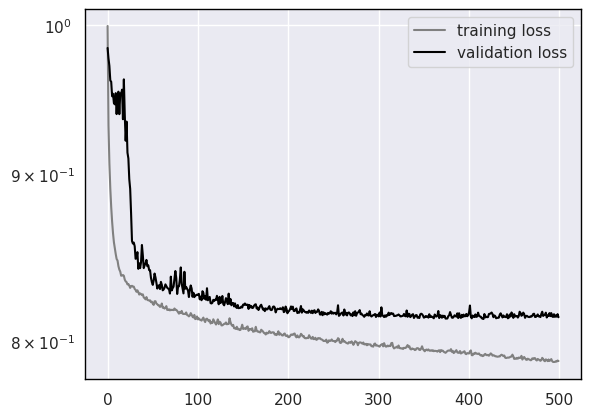

In [22]:
plt.semilogy(history.history['loss'], color='gray', label='training loss')
plt.semilogy(history.history['val_loss'], color='black', label='validation loss')
plt.legend()
plt.savefig('Figures/learning_curve')


In [23]:
if learning=='analysis':
    name = 'damodel'
else:
    name = 'true_model'
print(name)

damodel


In [24]:
# TODO model+scale save wrapper

    
model.save(dir['output'] / f'{name}_nn')
dump(scaler_x, open(dir['output'] / f'{name}_scalerx', 'wb'))
dump(scaler_y, open(dir['output'] / f'{name}_scalery', 'wb'))

INFO:tensorflow:Assets written to: Output/damodel_nn/assets


INFO:tensorflow:Assets written to: Output/damodel_nn/assets


## Validate the model (offline)

In [25]:
ypredict = scaler_y.inverse_transform(model.predict(scaler_x.transform(X)).squeeze())

157/157 [==============================] - 0s 2ms/step


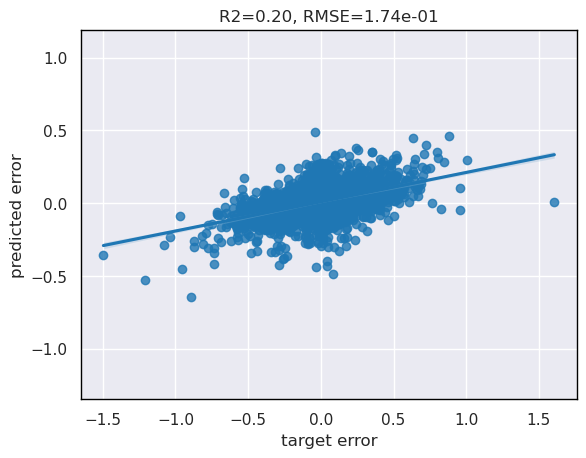

In [26]:
ax = scatter_plot (y[:,20], ypredict[:,20])
ax.set_xlabel('target error')
ax.set_ylabel('predicted error');
ax.axis('equal');

